In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import h5py
import numpy as np
from activ.analytics import heatmap
from activ.clustering import UmapClusteringResults
from os.path import dirname, join
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import label_binarize

In [2]:
f = h5py.File('/Users/ahyeon/Desktop/activ misc/predict_scores2.h5', 'r')

In [3]:
predictions = f['score'][:]
norm_predictions = f['norm_score'][:]
labels = f['clusters'][:]
umap_dims = f['umap_dimensions'][:]
cluster_sizes = f['cluster_sizes'][:]

In [4]:
def conf_alliter(size, predicted, actual):
    confalliter = []
    for j in range(50):
        conf = np.zeros((size,size))
        labs = list(map(int, actual[j][size-2]))
        preds = list(map(int, predicted[j][size-2]))
        for l, p in zip(labs, preds):
            conf[l,p] += 1
        confalliter.append(conf)
    return confalliter

In [12]:
def statistics(matrix):
    mat = np.matrix(matrix)
    i = mat.shape[0]-2
    tp = mat[i,i]
    tn = mat.sum() - mat[i,:].sum() - mat[:,i].sum() + mat[i,i]
    fp = mat[:,i].sum() - mat[i,i]
    fn = mat[i,:].sum() - mat[i,i]
    return tp, tn, fp, fn

In [15]:
def accuracy(mat):
    return mat.trace()/mat.sum()

def specificity(tn, fp):
    return tn/(tn+fp)

def sensitivity(tp, fn):
    return tp/(tp+fn)

def fscore(tp, fp, fn):
    return (2*tp)/(2*tp+fp+fn)

In [16]:
x = ([ 70,  52],[ 53,  72])

a,b,c,d = statistics(x)
a,b,c,d

(70, 72, 53, 52)

f 0.571428571429
f 0.641791044776
f 0.619047619048
f 0.540084388186
f 0.604651162791
f 0.574898785425
f 0.369863013699
f 0.602409638554
f 0.656826568266
f 0.573770491803
f 0.606299212598
f 0.566666666667
f 0.639405204461
f 0.896551724138
f 0.268656716418
f 0.55230125523
f 0.586345381526
f 0.582995951417
f 0.59778597786
f 0.556962025316
f 0.592
f 0.888888888889
f 0.569037656904
f 0.323529411765
f 0.543933054393
f 0.278260869565
f 0.55
f 0.557939914163
f 0.602409638554
f 0.269503546099
f 0.308823529412
f 0.533333333333
f 0.550847457627
f 0.544680851064
f 0.585365853659
f 0.323529411765
f 0.60162601626
f 0.564315352697
f 0.53781512605
f 0.563025210084
f 0.551440329218
f 0.573770491803
f 0.281481481481
f 0.544680851064
f 0.563265306122
f 0.521367521368
f 0.5703125
f 0.281481481481
f 0.6
f 0.559322033898
f_n 0.487804878049
f_n 0.546875
f_n 0.490272373541
f_n 0.497854077253
f_n 0.51711026616
f_n 0.525096525097
f_n 0.176
f_n 0.514285714286
f_n 0.625454545455
f_n 0.445344129555
f_n 0.45
f_n 0.

/Users/ahyeon/anaconda3/envs/activ/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/ahyeon/anaconda3/envs/activ/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


f_n 0.195652173913
f_n 0.192307692308
f_n 0.16091954023
f_n 0.190476190476
f_n 0.242990654206
f_n 0.262626262626
f_n 0.139534883721
f_n 0.15652173913
f_n 0.234042553191
f_n 0.202247191011
f_n 0.136363636364
f_n 0.159090909091
f_n 0.21978021978
f_n 0.133333333333
f_n 0.191304347826
f_n 0.197530864198
f_n 0.276422764228
f_n 0.1
f_n 0.164948453608
f_n 0.186046511628
f_n 0.278260869565
f_n 0.275229357798
f_n 0.178571428571
f_n 0.168674698795
f_n 0.144578313253
f_n 0.10989010989
f_n 0.175824175824
f_n 0.188679245283
f_n 0.3
f_n 0.190476190476
f_n 0.279069767442
f_n 0.175824175824
f 0.214285714286
f 0.0952380952381
f 0.215053763441
f 0.258620689655
f 0.231578947368
f 0.283185840708
f 0.282608695652
f 0.102564102564
f 0.190476190476
f 0.0
f 0.184615384615
f 0.0
f 0.229166666667
f 0.216666666667
f 0.276595744681
f 0.181818181818
f 0.255639097744
f 0.0
f 0.206896551724
f 0.218181818182
f 0.171428571429
f 0.260162601626
f 0.105263157895
f 0.225
f 0.142857142857
f 0.206896551724
f 0.163265306122


f 0.0512820512821
f 0.0540540540541
f 0.0
f 0.0
f 0.0
f 0.0
f 0.0
f 0.0
f 0.0
f 0.0444444444444
f 0.0377358490566
f 0.0
f 0.0701754385965
f 0.0526315789474
f 0.0
f 0.0377358490566
f 0.0
f 0.0645161290323
f 0.0
f 0.0
f 0.0
f 0.0487804878049
f 0.0408163265306
f 0.0434782608696
f 0.0
f 0.0645161290323
f 0.0
f 0.0
f 0.0
f 0.0416666666667
f 0.0
f 0.0
f 0.0
f 0.0
f 0.0
f 0.0
f 0.0
f 0.108108108108
f 0.0
f 0.0454545454545
f_n 0.0
f_n 0.0
f_n 0.19512195122
f_n 0.0
f_n 0.0
f_n 0.08
f_n 0.0
f_n 0.0
f_n 0.078431372549
f_n 0.0
f_n 0.0571428571429
f_n 0.181818181818
f_n 0.153846153846
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0454545454545
f_n 0.0869565217391
f_n 0.0
f_n 0.166666666667
f_n 0.0540540540541
f_n 0.0
f_n 0.08
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.105263157895
f_n 0.0
f_n 0.203389830508
f_n 0.0
f_n 0.0
f_n 0.0740740740741
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.117647058824
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0666666666667
f_n 0.0
f_n 0.0
f_n 0.170212765957
f_n 0.0416666666667
f_n 0

f 0.0
f 0.0
f 0.0
f 0.105263157895
f 0.0
f 0.0
f 0.0
f 0.190476190476
f 0.105263157895
f 0.0
f 0.0
f 0.266666666667
f 0.210526315789
f 0.222222222222
f 0.0
f 0.105263157895
f 0.117647058824
f 0.0
f 0.333333333333
f 0.105263157895
f 0.210526315789
f 0.117647058824
f 0.0
f 0.0952380952381
f 0.181818181818
f 0.0
f 0.105263157895
f 0.0
f 0.315789473684
f 0.125
f 0.0833333333333
f 0.105263157895
f 0.0
f 0.0
f_n 0.0606060606061
f_n 0.0
f_n 0.0666666666667
f_n 0.142857142857
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0869565217391
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0909090909091
f_n 0.222222222222
f_n 0.0
f_n 0.0
f_n 0.111111111111
f_n 0.0
f_n 0.0
f_n 0.111111111111
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.105263157895
f_n 0.0
f_n 0.0
f_n 0.25
f_n 0.0
f_n 0.0
f_n 0.1
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0740740740741
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f 0.0
f 0.133333333333
f 0.24
f 0.125
f 0.0
f 0.0
f 0.0
f 0.133333333333
f 0.0

f 0.181818181818
f 0.2
f 0.2
f 0.2
f 0.0
f 0.0
f 0.363636363636
f 0.0
f 0.0
f 0.2
f 0.0
f 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.153846153846
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.181818181818
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.166666666667
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f 0.333333333333
f 0.181818181818
f 0.0
f 0.0
f 0.166666666667
f 0.153846153846
f 0.0
f 0.222222222222
f 0.0
f 0.0
f 0.0
f 0.2
f 0.0
f 0.0
f 0.0
f 0.153846153846
f 0.0
f 0.2
f 0.333333333333
f 0.25
f 0.166666666667
f 0.0
f 0.181818181818
f 0.0
f 0.0
f 0.0
f 0.0
f 0.461538461538
f 0.363636363636
f 0.166666666667
f 0.25
f 0.0
f 0.0
f 0.0
f 0.2
f 0.181818181818
f 0.0
f 0.285714285714
f 0.181818181818
f 0.0
f 0.181818181818
f 0.181818181818
f 0.0
f 0.0
f 0.333333333333
f 0

f_n 0.333333333333
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.4
f_n 0.0
f_n 0.0
f_n 0.2
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f 0.153846153846
f 0.0
f 0.0
f 0.0
f 0.0
f 0.0
f 0.0
f 0.0
f 0.0
f 0.0
f 0.0
f 0.166666666667
f 0.0
f 0.0
f 0.0
f 0.0
f 0.0
f 0.0
f 0.0
f 0.0
f 0.0
f 0.0
f 0.0
f 0.0
f 0.0
f 0.0
f 0.0
f 0.0
f 0.0
f 0.2
f 0.0
f 0.0
f 0.0
f 0.0
f 0.0
f 0.0
f 0.0
f 0.0
f 0.0
f 0.0
f 0.0
f 0.0
f 0.0
f 0.0
f 0.0
f 0.0
f 0.0
f 0.0
f 0.0
f 0.0
f_n 0.285714285714
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.153846153846
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.222222222222
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.166666666667
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0
f_n 0.0

/Users/ahyeon/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:4274: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/ahyeon/anaconda3/envs/activ/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1872: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = np.compress(x <= hival, x)
/Users/ahyeon/anaconda3/envs/activ/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1879: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = np.compress(x >= loval, x)
/Users/ahyeon/anaconda3/envs/activ/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1887: RuntimeWarning: invalid value encountered in less
  np.compress(x < stats['whislo'], x),
/Users/ahyeon/anaconda3/envs/activ/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1888: RuntimeWarning: invalid value encountered in greater
  np.compress(x > stats['whishi'], x)


{'whiskers': [<matplotlib.lines.Line2D at 0x11a8b27f0>,
 'caps': [<matplotlib.lines.Line2D at 0x11a8aa1d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x11a8b2668>,
 'medians': [<matplotlib.lines.Line2D at 0x11a8aaa90>,
 'fliers': [],
 'means': []}

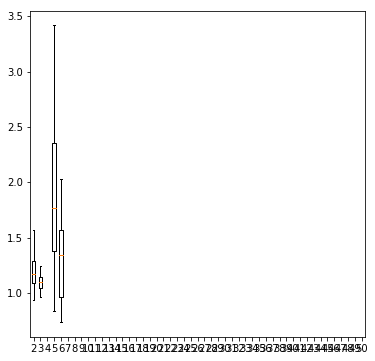

In [24]:
# fscore for class 2
fold_over_chance = np.zeros((len(cluster_sizes), 50))
for ii, c in enumerate(cluster_sizes):
    fscore_50 = []
    norm_fscore_50 = []
    all50mat = conf_alliter(c, predictions, labels)
    norm_all50mat = conf_alliter(c, norm_predictions, labels)

    for x in all50mat:
        tp, tn, fp, fn = statistics(x)
        f = fscore(tp, fp, fn)
        fscore_50.append(f)
        print('f',f)
        
    for y in norm_all50mat:
        tp_n, tn_n, fp_n, fn_n = statistics(y)
        
        f_n = fscore(tp_n, fp_n, fn_n)
        norm_fscore_50.append(f_n)
        print('f_n', f_n)
    
    foc = [j/k for j,k in zip(fscore_50, norm_fscore_50)]
    fold_over_chance[ii, :] = foc
    
plt.figure(figsize=(6,6))
plt.boxplot(fold_over_chance.T, labels = cluster_sizes, showfliers=False)


/Users/ahyeon/anaconda3/envs/activ/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


{'whiskers': [<matplotlib.lines.Line2D at 0x116ef8e48>,
 'caps': [<matplotlib.lines.Line2D at 0x116f05828>,
 'boxes': [<matplotlib.lines.Line2D at 0x116ef8cc0>,
 'medians': [<matplotlib.lines.Line2D at 0x116f0d128>,
 'fliers': [],
 'means': []}

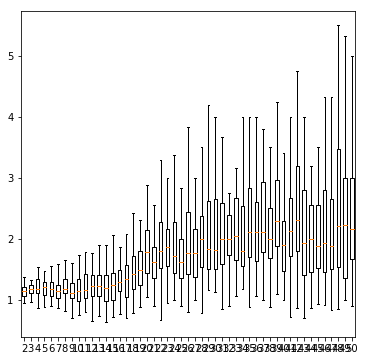

In [182]:
# accuracy
fold_over_chance = np.zeros((len(cluster_sizes), 50))

for ii,c in enumerate(cluster_sizes):
    all50mat = conf_alliter(c, predictions, labels)
    norm_all50mat = conf_alliter(c, norm_predictions, labels)
    acc = [accuracy(i) for i in all50mat]
    norm_acc = [accuracy(i) for i in norm_all50mat]
    foc = [x/y for x, y in zip(acc, norm_acc)]
    fold_over_chance[ii,:] = foc
fold_over_chance.shape

plt.figure(figsize=(6,6))
plt.boxplot(fold_over_chance.T, labels = cluster_sizes, showfliers=False)